In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML

%matplotlib inline 
# Set default style
sns.set()

In [2]:
%load_ext watermark

In [3]:
%watermark -iv -u -n -t -z

numpy       1.13.3
statsmodels 0.9.0
seaborn     0.9.0
matplotlib  3.0.3
pandas      0.24.2
last updated: Mon Apr 22 2019 13:00:22 Eastern Daylight Time


In [4]:
# File path
outbounds_file = 'Dataset/outbounds14to17.csv'

In [5]:
# Read in data as DataFrame
outbounds = pd.read_csv(outbounds_file, index_col=0, parse_dates=True)
display(outbounds)

,Europe,Caribbean,Asia,South America,Central America,Oceania,Middle East,Africa,Total Overseas,Mexico,Canada,North America,Grand Total
2014-01-31,577691.0,498620.0,376296.0,127749.0,219192.0,51774.0,140179.0,23982.0,2015483.0,2073218.50,450103.0,2523321.50,4538804.50
2014-02-28,497003.0,550203.0,312814.0,137612.0,225540.0,62658.0,119192.0,21066.0,1926088.0,1975580.80,483157.0,2458737.80,4384825.80
2014-03-31,806663.0,705211.0,397296.0,154680.0,283108.0,60097.0,140706.0,27950.0,2575711.0,2396038.50,553030.0,2949068.50,5524779.50
2014-04-30,868367.0,629774.0,381817.0,123068.0,213929.0,41314.0,141744.0,27596.0,2427609.0,2052385.20,662708.0,2715093.20,5142702.20
2014-05-31,1305842.0,624280.0,379197.0,144464.0,209012.0,46359.0,162244.0,36044.0,2907442.0,2123547.90,992697.0,3116244.90,6023686.90
2014-06-30,1614486.0,742860.0,424155.0,208023.0,301095.0,45003.0,180874.0,40542.0,3557038.0,2199477.20,1402535.0,3602012.20,7159050.20
2014-07-31,1413798.0,821650.0,397960.0,167627.0,308557.0,48892.0,148098.0,40732.0,3347314.0,2313740.60,1840827.0,4154567.60,7501881.60
2014-08-31,1185907.0,629224.0,342239.0,143609.0,206176.0,39913.0,145620.0,34231.0,2726919.0,2113128.80,1889787.0,4002915.80,6729834.80
2014-09-30,1241537.0,347244.0,338630.0,112581.0,121158.0,38013.0,133173.0,29205.0,2361541.0,1608221.30,1074367.0,2682588.30,5044129.30
2014-10-31,915090.0,436791.0,397721.0,123729.0,145848.0,46573.0,134341.0,25974.0,2226067.0,1875762.60,860615.0,2736377.60,4962444.60


In [6]:
# Test stationary of grand total
# The function takes in timeseries as parameter
def test_stationary(ts):
    df_test = adfuller(ts, autolag='AIC')
    df_result = pd.Series(df_test[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_result['Critical Value (%s)'%key] = value
    display(df_result)

In [7]:
# Seasonal decompose on input timeseries and plot the decomposition graphs
# return the decomposition object
def plot_decompose(ts):
    decomp = sm.tsa.seasonal_decompose(ts)
    fig = decomp.plot()
    fig.set_size_inches(5, 8)
    plt.show()
    return decomp

In [8]:
# Calculate normalized root mean square error
def rmse(actual, prediction):
    return np.true_divide(np.sqrt(mean_squared_error(actual, prediction)),np.mean(prediction)) 

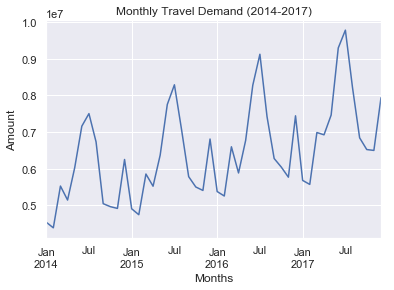

In [9]:
# Plot Overall 
outbounds.loc[:,'Grand Total'].plot()
plt.title("Monthly Travel Demand (2014-2017)")
plt.xlabel("Months")
plt.ylabel("Amount")
plt.show()

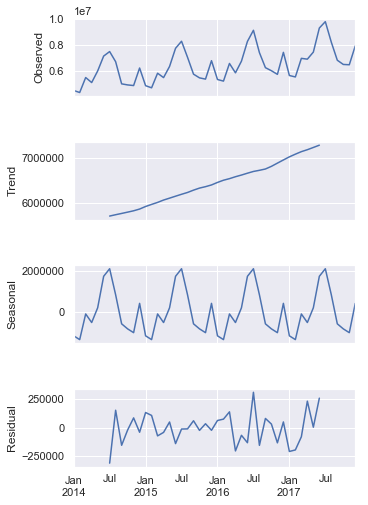

In [10]:
# Seasonal decomposition on Grand Total data
outbounds_decomp = plot_decompose(outbounds['Grand Total'])  

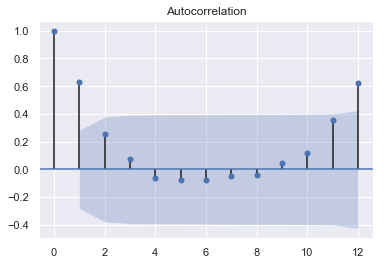

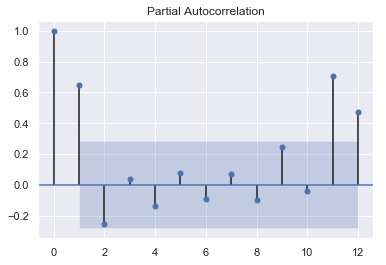

In [11]:
# ACF and PACF of Grand Total
tsaplots.plot_acf(outbounds['Grand Total'],lags=12)
tsaplots.plot_pacf(outbounds['Grand Total'], lags=12)
plt.show()

In [12]:
# Model data without differencing
orders = [(0,1,0),(0,1,1),(1,1,0),(1,1,1)]
seasonal_orders = [(1,0,0,12),(1,0,1,12),(1,1,0,12)]
trends = ['n','c','t','ct']
min_aic = np.inf
# Loop through each hyperparameters list
for order in orders:
    for seasonal_order in seasonal_orders:
        for trend in trends:
            model = SARIMAX(outbounds['Grand Total'], order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            print('SARIMA{}x{}: trend={}, AIC={}'.format(order, seasonal_order, trend, results.aic))
            # Check if the current model performs better
            if results.aic < min_aic:
                min_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_trend = trend
# print the best model and its hyperparamters
print('The best model is {}x{} with AIC:{} and trend:{}'.format(best_order, best_seasonal_order, min_aic, best_trend))

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=n, AIC=974.2784904108894
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=c, AIC=1042.3497555285915
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=t, AIC=1042.3910293357778
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=ct, AIC=1044.3050505385008


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=n, AIC=8860654.265785087
SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=c, AIC=8643426.328885317


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=t, AIC=8835118.477331419
SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=ct, AIC=8586090.125917353
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=n, AIC=645.5649940793651


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=c, AIC=647.8430886990416
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=t, AIC=647.8502190183925
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=ct, AIC=649.9255231600436


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 0, 0, 12): trend=n, AIC=1043.5872129857846
SARIMA(0, 1, 1)x(1, 0, 0, 12): trend=c, AIC=1045.7115594936438
SARIMA(0, 1, 1)x(1, 0, 0, 12): trend=t, AIC=1045.6844468687107
SARIMA(0, 1, 1)x(1, 0, 0, 12): trend=ct, AIC=1047.7115696346978

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



SARIMA(0, 1, 1)x(1, 0, 1, 12): trend=n, AIC=7561235.275397702


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 0, 1, 12): trend=c, AIC=7505961.252687197
SARIMA(0, 1, 1)x(1, 0, 1, 12): trend=t, AIC=7543821.296440147


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 0, 1, 12): trend=ct, AIC=7505969.646411006


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 0, 12): trend=n, AIC=636.2197620552877


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 0, 12): trend=c, AIC=639.0486773692519


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 0, 12): trend=t, AIC=637.9728100838577


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 0, 12): trend=ct, AIC=645.5062409902611
SARIMA(1, 1, 0)x(1, 0, 0, 12): trend=n, AIC=1012.6023230216446
SARIMA(1, 1, 0)x(1, 0, 0, 12): trend=c, AIC=1014.5899437935075


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 0, 0, 12): trend=t, AIC=1014.6351122522001
SARIMA(1, 1, 0)x(1, 0, 0, 12): trend=ct, AIC=1016.527082519392
SARIMA(1, 1, 0)x(1, 0, 1, 12): trend=n, AIC=8519697.161682243


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 0, 1, 12): trend=c, AIC=8307687.170291895
SARIMA(1, 1, 0)x(1, 0, 1, 12): trend=t, AIC=8487089.625012632


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 0, 1, 12): trend=ct, AIC=8244602.561768178
SARIMA(1, 1, 0)x(1, 1, 0, 12): trend=n, AIC=613.1092352383444


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 1, 0, 12): trend=c, AIC=615.1163107440525
SARIMA(1, 1, 0)x(1, 1, 0, 12): trend=t, AIC=615.1037290838627


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 1, 0, 12): trend=ct, AIC=617.2663146755503
SARIMA(1, 1, 1)x(1, 0, 0, 12): trend=n, AIC=1015.2570786138331


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 0, 0, 12): trend=c, AIC=1017.3081923869084
SARIMA(1, 1, 1)x(1, 0, 0, 12): trend=t, AIC=1017.2950189617934


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 0, 0, 12): trend=ct, AIC=1019.3070403753853
SARIMA(1, 1, 1)x(1, 0, 1, 12): trend=n, AIC=7137420.903692624


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 0, 1, 12): trend=c, AIC=7097917.820891746
SARIMA(1, 1, 1)x(1, 0, 1, 12): trend=t, AIC=7112303.554648523


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 0, 1, 12): trend=ct, AIC=7098566.057217245


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 0, 12): trend=n, AIC=611.7607592793313


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 0, 12): trend=c, AIC=614.2963419036552


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 0, 12): trend=t, AIC=613.4745774060789


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 0, 12): trend=ct, AIC=618.7242696394501
The best model is (1, 1, 1)x(1, 1, 0, 12) with AIC:611.7607592793313 and trend:n


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


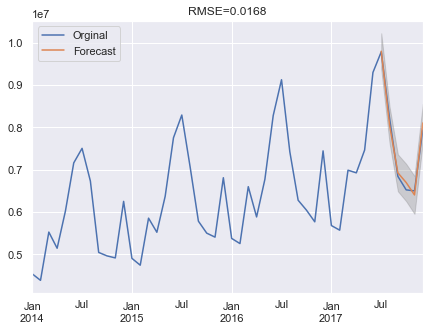

In [13]:
# Create SARIMA model with the best hyperparameters
model_raw = SARIMAX(outbounds['Grand Total'], order=best_order, seasonal_order=best_seasonal_order, trend=best_trend, enforce_stationarity=False, enforce_invertibility=False)
# Fit the model
results_raw = model_raw.fit()
# Create the date range for prediction
dates_r = pd.date_range(start='2017-07', end='2017-12-31', freq='M')
# Predict
pred_raw = results_raw.get_prediction(start=dates_r[0], end=dates_r[-1], freq='M', dynamic=True)
# Get the 95% confidence interval
pred_r_ci = pred_raw.conf_int()
# predicted values
pred_r = pred_raw.predicted_mean
# Plot the predictions and original data
ax = outbounds['Grand Total'].plot(label='Orginal', figsize=(7,5))
pred_r.plot(label='Forecast')
ax.fill_between(pred_r_ci.index, pred_r_ci.iloc[:,0], pred_r_ci.iloc[:,1], color='grey', alpha=0.3)
plt.legend(loc='upper left')
plt.title('RMSE={:.4f}'.format(rmse(outbounds['Grand Total'].loc[dates_r], pred_r)))
plt.show()

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


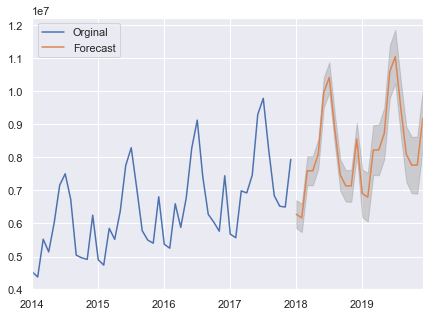

In [14]:
# Forecast 2018 and 2019
# Create date range for prediction
dates1819 = pd.date_range(start='2018-01', end='2019-12-31', freq='M')
# Predict
pred_1819 = results_raw.get_prediction(start=dates1819[0], end=dates1819[-1], freq='M', dynamic=True)
# Get the 95% confidence interval
pred1819_ci = pred_1819.conf_int()
# Get the predictions
predictions1819 = pred_1819.predicted_mean
# Plot the predictions and original data
ax = outbounds['Grand Total'].plot(label='Orginal', figsize=(7,5))
predictions1819.plot(label='Forecast')
ax.fill_between(pred1819_ci.index, pred1819_ci.iloc[:,0], pred1819_ci.iloc[:,1], color='grey', alpha=0.3)
plt.legend(loc='upper left')
plt.show()

2014-01-31    15.328174
2014-02-28    15.293660
2014-03-31    15.524754
2014-04-30    15.453089
2014-05-31    15.611210
Name: Grand Total, dtype: float64

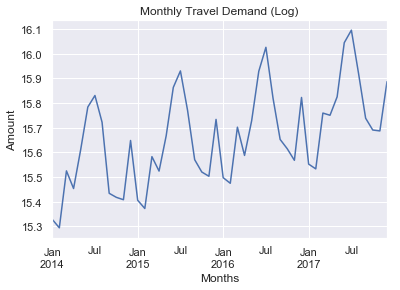

Test Statistic                 -0.430652
p-value                         0.904854
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64

In [15]:
# Check data with logarithm
total_log = outbounds['Grand Total'].apply(lambda x: np.log(x))
display(total_log.head())
total_log.plot()
plt.title("Monthly Travel Demand (Log)")
plt.xlabel('Months')
plt.ylabel('Amount')
plt.show()
# Test stationarity
test_stationary(total_log)

2014-02-28   -0.034514
2014-03-31    0.231093
2014-04-30   -0.071665
2014-05-31    0.158121
2014-06-30    0.172678
Name: Grand Total, dtype: float64

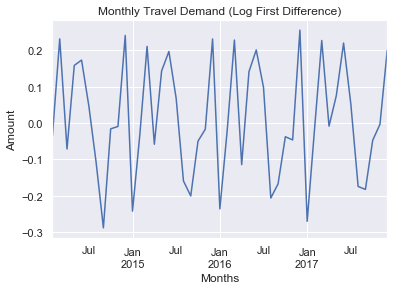

Test Statistic                -30.278580
p-value                         0.000000
#Lags Used                     10.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64

In [16]:
# Log data with first differencing to remove trend
log_first_difference = total_log.diff().dropna()
display(log_first_difference.head())
log_first_difference.plot()
plt.title("Monthly Travel Demand (Log First Difference)")
plt.xlabel('Months')
plt.ylabel('Amount')
plt.show()
# Test stationarity
test_stationary(log_first_difference)

2014-02-28    -153978.7
2014-03-31    1139953.7
2014-04-30    -382077.3
2014-05-31     880984.7
2014-06-30    1135363.3
Name: Grand Total, dtype: float64

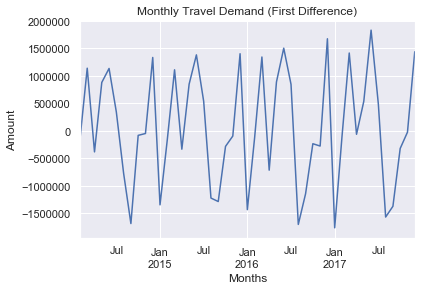

Test Statistic                -27.553492
p-value                         0.000000
#Lags Used                     10.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64

In [17]:
# Data with first differencing to remove trend
first_difference = outbounds['Grand Total'].diff().dropna()
display(first_difference.head())
first_difference.plot()
plt.title("Monthly Travel Demand (First Difference)")
plt.xlabel('Months')
plt.ylabel('Amount')
plt.show()
# Test stationarity
test_stationary(first_difference)

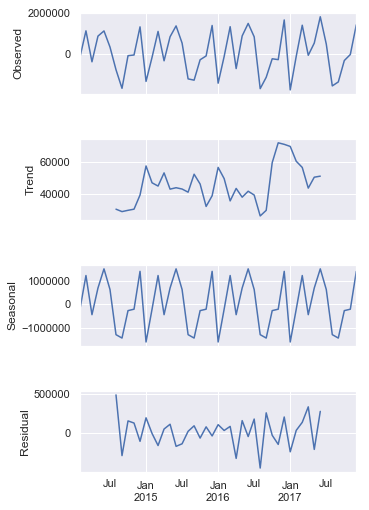

In [18]:
# Check seasonal decomosition
first_difference_decomp = plot_decompose(first_difference)

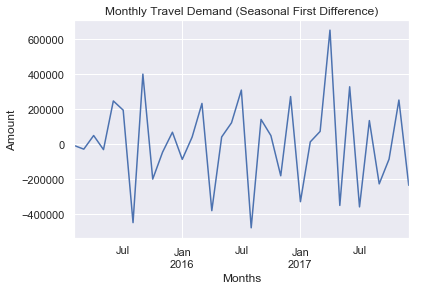

Test Statistic                -1.068986e+01
p-value                        3.750151e-19
#Lags Used                     0.000000e+00
Number of Observations Used    3.400000e+01
Critical Value (1%)           -3.639224e+00
Critical Value (5%)           -2.951230e+00
Critical Value (10%)          -2.614447e+00
dtype: float64

In [19]:
# Seasonal first dirrencing of the data
seasonal_first_difference = first_difference.diff(12).dropna()
seasonal_first_difference.plot()
plt.title("Monthly Travel Demand (Seasonal First Difference)")
plt.xlabel('Months')
plt.ylabel('Amount')
plt.show()
# Test stationarity
test_stationary(seasonal_first_difference)

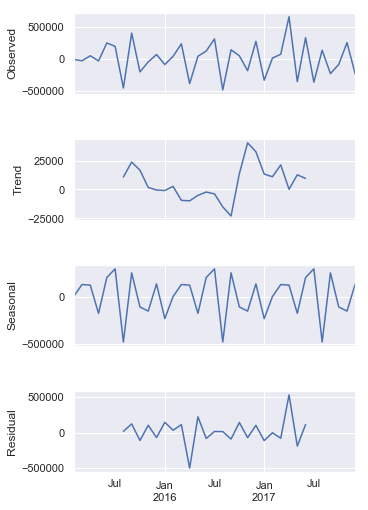

In [20]:
# Check seasonal decomposition
seasonal_first_difference_decomp = plot_decompose(seasonal_first_difference)

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


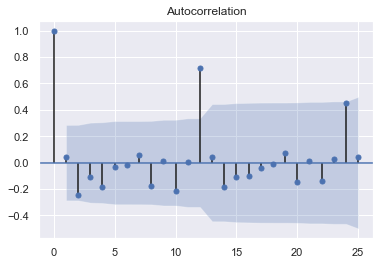

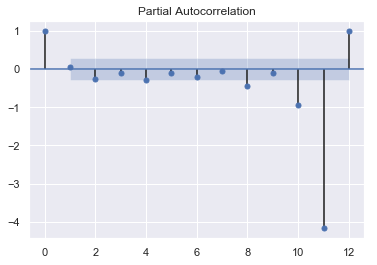

In [21]:
# ACF and PACF of First Difference
tsaplots.plot_acf(first_difference, lags=25)
tsaplots.plot_pacf(first_difference, lags=12)
plt.show()

In [22]:
# Model data after stationarized
# Find the best perform model
orders = [(0,0,0),(2,0,0),(0,1,0),(2,1,0),(2,0,1)]
seasonal_orders = [(1,0,0,12),(1,0,1,12),(1,1,0,12),(0,1,0,12)]
trends = ['n','c','t','ct']
min_aic = np.inf
# Loop through each list
for order in orders:
    for seasonal_order in seasonal_orders:
        for trend in trends:
            model = SARIMAX(first_difference, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            print('SARIMA{}x{}: trend={}, AIC={}'.format(order, seasonal_order, trend, results.aic))
            # Compare if this model performs better
            if results.aic < min_aic:
                min_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_trend = trend
# Print the best model and its hyperparamters
print('The best model is {}x{} with AIC:{} and trend:{}'.format(best_order, best_seasonal_order, min_aic, best_trend))

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: N

SARIMA(0, 0, 0)x(1, 0, 0, 12): trend=n, AIC=974.2784904108896
SARIMA(0, 0, 0)x(1, 0, 0, 12): trend=c, AIC=1042.3497555285912
SARIMA(0, 0, 0)x(1, 0, 0, 12): trend=t, AIC=1042.3836605116683
SARIMA(0, 0, 0)x(1, 0, 0, 12): trend=ct, AIC=1044.3102055183836


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(1, 0, 1, 12): trend=n, AIC=10671167.312834509
SARIMA(0, 0, 0)x(1, 0, 1, 12): trend=c, AIC=10653721.212474503
SARIMA(0, 0, 0)x(1, 0, 1, 12): trend=t, AIC=10711765.95456916


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(1, 0, 1, 12): trend=ct, AIC=10639945.553913023
SARIMA(0, 0, 0)x(1, 1, 0, 12): trend=n, AIC=645.5649940793651
SARIMA(0, 0, 0)x(1, 1, 0, 12): trend=c, AIC=647.8430886990416
SARIMA(0, 0, 0)x(1, 1, 0, 12): trend=t, AIC=647.8496818136817


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so infe

SARIMA(0, 0, 0)x(1, 1, 0, 12): trend=ct, AIC=649.9106474353143
SARIMA(0, 0, 0)x(0, 1, 0, 12): trend=n, AIC=948.2149279579232
SARIMA(0, 0, 0)x(0, 1, 0, 12): trend=c, AIC=948.2303051852116
SARIMA(0, 0, 0)x(0, 1, 0, 12): trend=t, AIC=948.2445088109582
SARIMA(0, 0, 0)x(0, 1, 0, 12): trend=ct, AIC=950.2424167702162
SARIMA(2, 0, 0)x(1, 0, 0, 12): trend=n, AIC=982.6881168623834

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



SARIMA(2, 0, 0)x(1, 0, 0, 12): trend=c, AIC=984.658686355576


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 0)x(1, 0, 0, 12): trend=t, AIC=984.7139765165583
SARIMA(2, 0, 0)x(1, 0, 0, 12): trend=ct, AIC=986.6610671382151


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 0)x(1, 0, 1, 12): trend=n, AIC=9346393.197596977
SARIMA(2, 0, 0)x(1, 0, 1, 12): trend=c, AIC=9458697.538537623


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 0)x(1, 0, 1, 12): trend=t, AIC=9395250.754667401


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 0)x(1, 0, 1, 12): trend=ct, AIC=9456840.990747469
SARIMA(2, 0, 0)x(1, 1, 0, 12): trend=n, AIC=586.8784489035874


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 0)x(1, 1, 0, 12): trend=c, AIC=589.049433127742
SARIMA(2, 0, 0)x(1, 1, 0, 12): trend=t, AIC=588.9101309217248


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 0)x(1, 1, 0, 12): trend=ct, AIC=591.2481592849873
SARIMA(2, 0, 0)x(0, 1, 0, 12): trend=n, AIC=908.9972047809905
SARIMA(2, 0, 0)x(0, 1, 0, 12): trend=c, AIC=910.8592041421721
SARIMA(2, 0, 0)x(0, 1, 0, 12): trend=t, AIC=910.9624194489306
SARIMA(2, 0, 0)x(0, 1, 0, 12): trend=ct, AIC=913.0823906411578


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so infe

SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=n, AIC=986.5706834612171
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=c, AIC=1036.163376786911
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=t, AIC=1036.194302278751
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=ct, AIC=1038.2011617966577


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=n, AIC=18359927.91772217


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=c, AIC=18555927.61347512
SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=t, AIC=18431814.12019585


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=ct, AIC=17717874.414892886
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=n, AIC=643.0856378663319
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=c, AIC=645.3298974083959
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=t, AIC=645.3346553565444


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=ct, AIC=647.3596929253553
SARIMA(0, 1, 0)x(0, 1, 0, 12): trend=n, AIC=959.0541239891851
SARIMA(0, 1, 0)x(0, 1, 0, 12): trend=c, AIC=958.7339544635644
SARIMA(0, 1, 0)x(0, 1, 0, 12): trend=t, AIC=958.735780343444
SARIMA(0, 1, 0)x(0, 1, 0, 12): trend=ct, AIC=960.747846618754
SARIMA(2, 1, 0)x(1, 0, 0, 12): trend=n, AIC=966.9757596199801


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so infe

SARIMA(2, 1, 0)x(1, 0, 0, 12): trend=c, AIC=968.9771862198334
SARIMA(2, 1, 0)x(1, 0, 0, 12): trend=t, AIC=969.008459167426


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 1, 0)x(1, 0, 0, 12): trend=ct, AIC=971.0207427243895
SARIMA(2, 1, 0)x(1, 0, 1, 12): trend=n, AIC=13808667.529164273


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 1, 0)x(1, 0, 1, 12): trend=c, AIC=13863716.93437422
SARIMA(2, 1, 0)x(1, 0, 1, 12): trend=t, AIC=13845037.194419725


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 1, 0)x(1, 0, 1, 12): trend=ct, AIC=13788507.5053892
SARIMA(2, 1, 0)x(1, 1, 0, 12): trend=n, AIC=570.0896443558102


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 1, 0)x(1, 1, 0, 12): trend=c, AIC=572.0910704158741
SARIMA(2, 1, 0)x(1, 1, 0, 12): trend=t, AIC=572.0950913313865


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 1, 0)x(1, 1, 0, 12): trend=ct, AIC=574.0981203043195
SARIMA(2, 1, 0)x(0, 1, 0, 12): trend=n, AIC=899.6455832233139
SARIMA(2, 1, 0)x(0, 1, 0, 12): trend=c, AIC=901.6454975465603
SARIMA(2, 1, 0)x(0, 1, 0, 12): trend=t, AIC=901.6457059670715
SARIMA(2, 1, 0)x(0, 1, 0, 12): trend=ct, AIC=903.6466660660611


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so infe

SARIMA(2, 0, 1)x(1, 0, 0, 12): trend=n, AIC=984.6834418360249


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 0, 0, 12): trend=c, AIC=986.711702709714


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 0, 0, 12): trend=t, AIC=986.6849996587115


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 0, 0, 12): trend=ct, AIC=988.7947759947459


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 0, 1, 12): trend=n, AIC=9346394.570946721


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 0, 1, 12): trend=c, AIC=9503541.165638855
SARIMA(2, 0, 1)x(1, 0, 1, 12): trend=t, AIC=9397801.028909326


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 0, 1, 12): trend=ct, AIC=9577407.531125208


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 1, 0, 12): trend=n, AIC=584.484510094822


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 1, 0, 12): trend=c, AIC=589.1357903273523


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 1, 0, 12): trend=t, AIC=585.2665275417114


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(1, 1, 0, 12): trend=ct, AIC=593.1874492912464


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(0, 1, 0, 12): trend=n, AIC=905.2997248101324


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(0, 1, 0, 12): trend=c, AIC=911.753003450117


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(0, 1, 0, 12): trend=t, AIC=906.357503375066


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(2, 0, 1)x(0, 1, 0, 12): trend=ct, AIC=915.1552548957578
The best model is (2, 1, 0)x(1, 1, 0, 12) with AIC:570.0896443558102 and trend:n


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


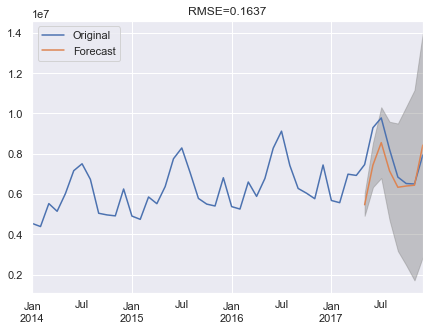

In [23]:
# Create SARIMA model with best hyperparameters
model = SARIMAX(first_difference, order=best_order, seasonal_order=best_seasonal_order, trend=best_trend, enforce_stationarity=False, enforce_invertibility=False)
# Fit the model
model_fit = model.fit()
# Create a date range for prediction
dates = pd.date_range(start=pd.to_datetime('2017-05-31'), end=pd.to_datetime('2017-12-31'), freq='M')
# Predict
pred = model_fit.get_prediction(start=dates[0], end=dates[-1], freq='M', dynamic=True)
# Get the confidence interval
pred_ci = pred.conf_int().cumsum().add(outbounds['Grand Total'].iloc[0])
# Get the predicted values
predictions = pred.predicted_mean.cumsum().add(outbounds['Grand Total'].iloc[0])
# Plot original data and predicted values
ax = outbounds['Grand Total'].plot(label='Original', figsize=(7,5))
predictions.plot(label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='grey', alpha=0.4)
plt.legend(loc='upper left')
plt.title('RMSE={:.4f}'.format(rmse(outbounds['Grand Total'].loc[dates], predictions)))
plt.show()

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


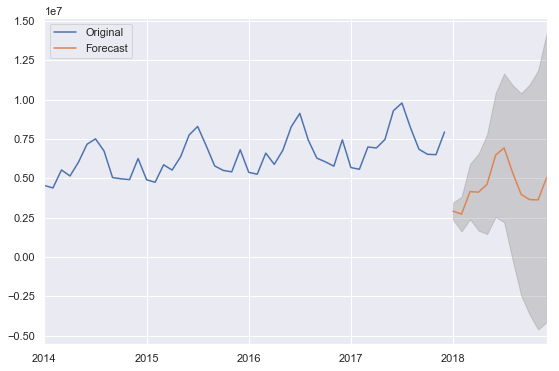

In [24]:
# Forecast the next 12 months
# Create a date range for prediction
dates_2018 = pd.date_range(start=pd.to_datetime('2018-01'), end=pd.to_datetime('2018-12-31'), freq='M')
# Predict
pred_2018 = model_fit.get_prediction(start=dates_2018[0], end=dates_2018[-1], dynamic=True)
# Get the 95% confidence interval
pred18_ci = pred_2018.conf_int().cumsum().add(outbounds['Grand Total'].iloc[0])
# Get the predicted values
pred18 = pred_2018.predicted_mean.cumsum().add(outbounds['Grand Total'].iloc[0])
# Plot the original data and predicted values
ax = outbounds['Grand Total'].plot(label='Original', figsize=(9,6))
pred18.plot(label='Forecast')
ax.fill_between(pred18_ci.index, pred18_ci.iloc[:,0], pred18_ci.iloc[:,1], color='grey', alpha=0.3)
plt.legend(loc='upper left')
plt.show()